<a href="https://colab.research.google.com/github/alirempel/cap-comp215/blob/main/project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline

import time
from pprint import pprint

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import animation
from scipy.signal import correlate2d

# Configure matplotlib's animation library to work in the browser.
matplotlib.rc('animation', html='jshtml')

In [2]:
# Qualitative colour map with value 0 set to white
tab20_mod = matplotlib.colormaps['tab20']
tab20_mod.colors = ((1,1,1,1), *tab20_mod.colors[1:])

def plot_2d_array(array, axes=None, title='', cmap=tab20_mod, **options):
    """
    Plot the 2D array as an image on the given axes  1's will be dark blue, 0's will be light blue.

    :param axes: the axes to plot on, or None to use the `plt.gca()` (current axes)
    :param options: keyword arguments passed directly to `plt.imshow()`
           see https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.imshow.html
    """
    axes = axes or plt.gca()  # If not axes are provided, draw on current axes
    axes.set_title(title)
    # Turn off axes labels and tick marks
    axes.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False ,
                     labelbottom=False, labeltop=False, labelleft=False, labelright=False,)
    # Defaults for displaying a "matrix" with hard-pixel boundaries and (0,0) at top-left
    options = {**dict(interpolation='nearest', origin='upper'), **options}
    axes.imshow(array, cmap=cmap, **options)

In [3]:
class Animation2D:
    """
      Animates any 2D model with a step() method and a draw() method, using matplotlib
      model.step() should take no parameters - just step the model forward one step.
      model.draw() should take 2 parameters, the matpltolib axes to draw on and an integer step number

      See https://www.allendowney.com/blog/2019/07/25/matplotlib-animation-in-jupyter/
          for a discussion of the pros and cons of various animation techniques in jupyter notebooks
    """

    def __init__(self, model, frames=50, steps_per_frame=1, figsize=(8, 8)):
        """
        :param model: the simulation object to animate, with step() and draw(axes, step) methods
        :param frames: number of animation frames to generate
        """
        self.model = model
        self.frames = frames
        self.steps_per_frame = steps_per_frame
        self.fig, self.ax = plt.subplots(figsize=figsize)

    def animation_step(self, step):
        """ Step the model forward and draw the plot """
        if step > 0:
            for _ in range(self.steps_per_frame):
                self.model.step()
        self.model.draw(self.ax, step=step * self.steps_per_frame)

    def show(self):
        """ return the matplotlib animation object, ready for display """
        anim = animation.FuncAnimation(self.fig, self.animation_step, frames=self.frames)
        plt.close()  # this ensures the last frame is not shown as a separate plot
        return anim

    def animate(self, interval=None):
        """ Animate the model simulation directly in the notebook display block """
        from IPython.display import clear_output
        try:
            for i in range(self.frames):
                clear_output(wait=True)  # clear the IPython display
                self.ax.clear()  # clear old image from the axes (fixes a performance issue)
                plt.figure(self.fig)  # add the figure back to pyplot ** sigh **
                self.animation_step(i)
                plt.show()  # show the current animation frame (pyplot then closes and throws away figure ** sigh **)
                if interval:
                    time.sleep(interval)
        except KeyboardInterrupt:
            pass

In [37]:
class Deer:
    """ 2D Cellular Automaton that simulates a deer-populated landscape """

    # Define names for the 3 possible cell states
    EMPTY = 0
    OCCUPIED = 1
    DEER = 5

    # Define a colour map that maps each cell state to an intuitive colour.
    cmap = [(1, 0.5, 0), (0, 1, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (1, 0, 0)]
    cmap[EMPTY] = (1, 0.5, 0)  # brown
    cmap[OCCUPIED] = (0, 1, 0)  # green
    cmap[DEER] = (1, 0, 0)  # red
    forest_colour_map = matplotlib.colors.ListedColormap(cmap)

    # TODO: define a sensible correlation kernel to detect cardinal neighbourhood on fire
    kernel = np.array([[0, 1, 0],
                       [1, 1, 1],
                       [0, 1, 0]])


    def __init__(self, n, p=0.01,g = 0.5, q=0.5):
        """Initializes the model.

        n: number of rows
        p: probability an empty cells grows grass (becomes occupied)
        g: grazing rate
        q: initial grass density (probability cell has grass (is occupied) in initial state)
        """
        self.p = p
        self.g = g
        # initialize landscape with approx. q proportion of cells OCCUPIED
        self.state = np.random.choice([self.OCCUPIED, self.EMPTY], (n, n), p=[q, 1 - q])

    def add_deer(self,positions = [(0,0),(1,1)]):
      '''Adds deer to landscape in positions specified.

      positions: list of tuples containing row,column coords for deer to be placed
      '''
      for row,col in positions:
        self.state[row][col] = self.DEER


    def step(self):
        """Executes one time step, applying the CA rules to regenerate and burn forest."""
        # TODO: define the rules for the CA.  This is a significant challenge b/c there are 4 rules and they must act independently!
        # Tips: develop 1 rule at a time, in the order above, leaving fire spread (correlation) till last.
        #       Compute each rule in 2 steps: (1) identify which cells the rule applies to; (2) update those cells.
        #       Use the next code block, below, to test as you go.

        is_empty = self.state == self.EMPTY
        is_occupied = self.state == self.OCCUPIED
        has_deer = self.state == self.DEER


        self.state[is_empty] = np.random.choice([self.OCCUPIED,self.EMPTY], len(self.state[is_empty]), 1, (self.p, 1-self.p))
        self.state[has_deer] = np.random.choice([self.EMPTY,self.OCCUPIED], len(self.state[has_deer]), 1, (self.g, 1-self.g))


    def num_occupied(self):
        """ return the number of cells occupied by grass """
        return len(self.state[self.state == self.OCCUPIED])  # count the number of cells with grass.


    def pct_occupied(self):
        """ return the proportion of cells occupied by grass """
        return self.num_occupied() / self.state.size


    def draw(self, axes=None, step=''):
        """Draws the CA cells using the forest colour map so values are coloured intuitively."""
        axes = axes or plt.gca()
        title = f'Time:{step} Occupied: {round(self.pct_occupied() * 100, 2)}%'
        plot_2d_array(self.state, axes=axes, title=title,
                      cmap=self.forest_colour_map, vmin=0, vmax=len(self.forest_colour_map.colors))

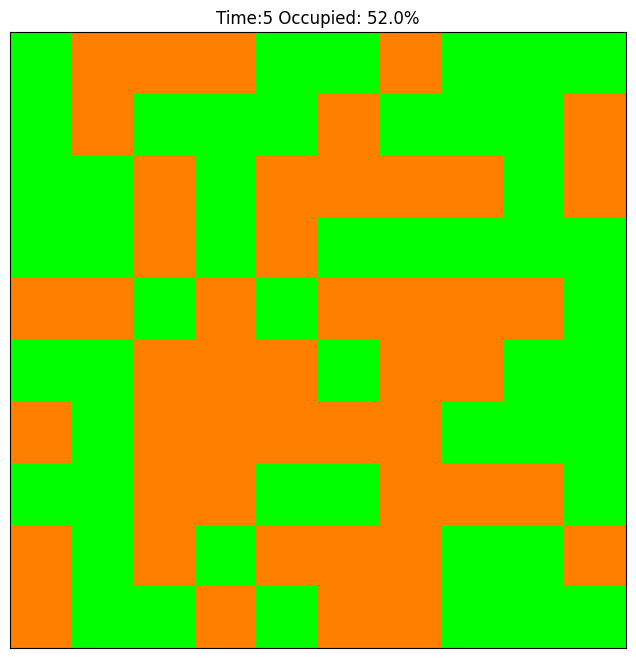

In [39]:
deer = Deer(10)
deer.add_deer()
deer_an = Animation2D(model=deer)
deer_an.animate(interval=.1)